# Gett - Insights from Failed Orders

## Table of Contents
* [Assignment](#Assignment)
* [Data Description](#Data-Description)
* [Data Exploration](#Data-Exploration)
* [Question 1](#Question-1)
* [Question 2](#Question-2)
* [Question 3](#Question-3)
* [Question 4](#Question-4)
* [Question 5](#Question-5)

## Assignment

They have an application where clients can order taxis, and drivers can accept their rides (offers). At the moment, when the client clicks the Order button in the application, the matching system searches for the most relevant drivers and offers them the order. In this task, we would like to investigate some matching metrics for orders that did not completed successfully, i.e., the customer didn't end up getting a car.

Please complete the following tasks.

**1.** Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyze the resulting plot. Which category has the highest number of orders?

**2.** Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest failures? How can this be explained?

**3.** Plot the average time to cancellation with and without a driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

**4.** Plot the distribution of average ETA by hours. How can this plot be explained?

**5. BONUS Hexagons.** Using the h3 and folium packages, calculate how many sizes 8 hexes contain 80% of all orders from the original data sets and visualize the hexes, coloring them by the number of fails on the map.

## Data Description
### We have two data sets: data_orders and data_offers, both being stored in a CSV format. The data_orders data set contains the following columns:

**order_datetime:**  time of the order

**origin_longitude:** longitude of the order

**origin_latitude:** latitude of the order

**m_order_eta:** time before order arrival

**order_gk:** order number

**order_status_key:** status, an enumeration consisting of the following mapping:
        
        4 - cancelled by client,
        9 - cancelled by system, i.e., a reject
        
**is_driver_assigned_key:** whether a driver has been assigned

**cancellation_time_in_seconds:** how many seconds passed before cancellation


### The data_offers data set is a simple map with 2 columns:

**order_gk:** order number, associated with the same column from the orders data set

**offer_id:** ID of an offer

## Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_offers = pd.read_csv('data_offers.csv')
data_offers.head(3)

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812


In [3]:
data_orders = pd.read_csv('data_orders.csv')
data_orders.head(3)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0


In [8]:
data = data_orders.merge(right = data_offers, how = 'inner', on = 'order_gk')
data.head(3)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,300050983403
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986179
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986174


We may be able to do something to improve the data quality a bit. For example, the values in order_status_key and is_driver_assigned_key are not informative of the contents, but are rather just keys that point to some internal description. We could replace their values with more informative information, like replacing the 1s in is_driver_assigned_key with the string Yes and the 0s with the string No. Same can be done for the order_status_key column. Moreover, the names of the columns sound a bit technical, but we can modify them.

In [9]:
data['is_driver_assigned'] = np.where(data['is_driver_assigned_key'] == 1, 'Yes', 'No')

data['order_status'] = np.where(data['order_status_key'] == 4, 'Client Cancelled', 'System Reject')

data.drop(columns = ['is_driver_assigned_key', 'order_status_key'], inplace = True)

data = data.rename(columns = {'order_datetime' : 'order_time'})

data.head(3)

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,cancellations_time_in_seconds,offer_id,is_driver_assigned,order_status
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,198.0,300050983403,Yes,Client Cancelled
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986179,No,Client Cancelled
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986174,No,Client Cancelled


## Question 1
Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyze the resulting plot. Which category has the highest number of orders?


In [19]:
data_question_1 = data.pivot_table(columns = ['is_driver_assigned', 'order_status'], values = 'order_gk',
                                   aggfunc = 'count')

data_question_1

is_driver_assigned               No                            Yes  \
order_status       Client Cancelled System Reject Client Cancelled   
order_gk                      13435          9469             8360   

is_driver_assigned                
order_status       System Reject  
order_gk                       4

<AxesSubplot:>

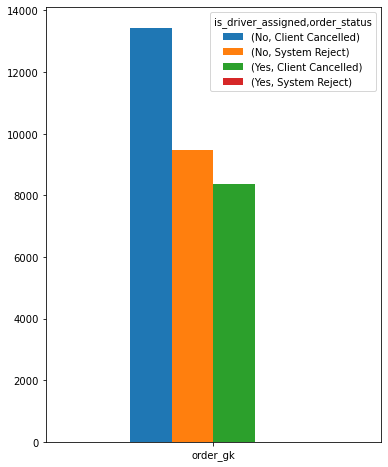

In [20]:
data_question_1.plot(kind = 'bar', subplots = False, figsize = (6,8), legend = True, rot = 0)

## Question 2
Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest failures? How can this be explained?